# Workload Analysis

This notebook identify representative workload classes (e.g., short CPU-bound jobs, GPU-heavy jobs, data-intensive analytics, multi-node MPI jobs, etc.) from Perlmutter job traces.


We'll implement K-means clustering and use the elbow method to find the optimal number of clusters, with progress visualization using tqdm.

**Imports**

In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
import seaborn as sns
import time
from sklearn.decomposition import PCA

**Load and Explore Dataset**

In [2]:
# Load the iris dataset
iris = load_iris()
features = iris.feature_names
target = iris.target_names

# Convert to polars DataFrame
df = pl.DataFrame({
    features[0]: iris.data[:, 0],
    features[1]: iris.data[:, 1],
    features[2]: iris.data[:, 2],
    features[3]: iris.data[:, 3],
    'species': [target[i] for i in iris.target]
})

# Display the first few rows
print("Iris Dataset Sample:")
display(df.head())

# Show basic statistics
print("\nDataset Statistics:")
display(df.describe())

# Count the species
print("\nSpecies Distribution:")
display(df.group_by('species').agg(pl.len().alias('count')))

Iris Dataset Sample:


sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
f64,f64,f64,f64,str
5.1,3.5,1.4,0.2,"""setosa"""
4.9,3.0,1.4,0.2,"""setosa"""
4.7,3.2,1.3,0.2,"""setosa"""
4.6,3.1,1.5,0.2,"""setosa"""
5.0,3.6,1.4,0.2,"""setosa"""



Dataset Statistics:


statistic,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
str,f64,f64,f64,f64,str
"""count""",150.0,150.0,150.0,150.0,"""150"""
"""null_count""",0.0,0.0,0.0,0.0,"""0"""
"""mean""",5.843333,3.057333,3.758,1.199333,null
"""std""",0.828066,0.435866,1.765298,0.762238,null
"""min""",4.3,2.0,1.0,0.1,"""setosa"""
"""25%""",5.1,2.8,1.6,0.3,null
"""50%""",5.8,3.0,4.4,1.3,null
"""75%""",6.4,3.3,5.1,1.8,null
"""max""",7.9,4.4,6.9,2.5,"""virginica"""



Species Distribution:


species,count
str,u32
"""virginica""",50
"""setosa""",50
"""versicolor""",50


**Data Visualization**

<Figure size 1500x1000 with 0 Axes>

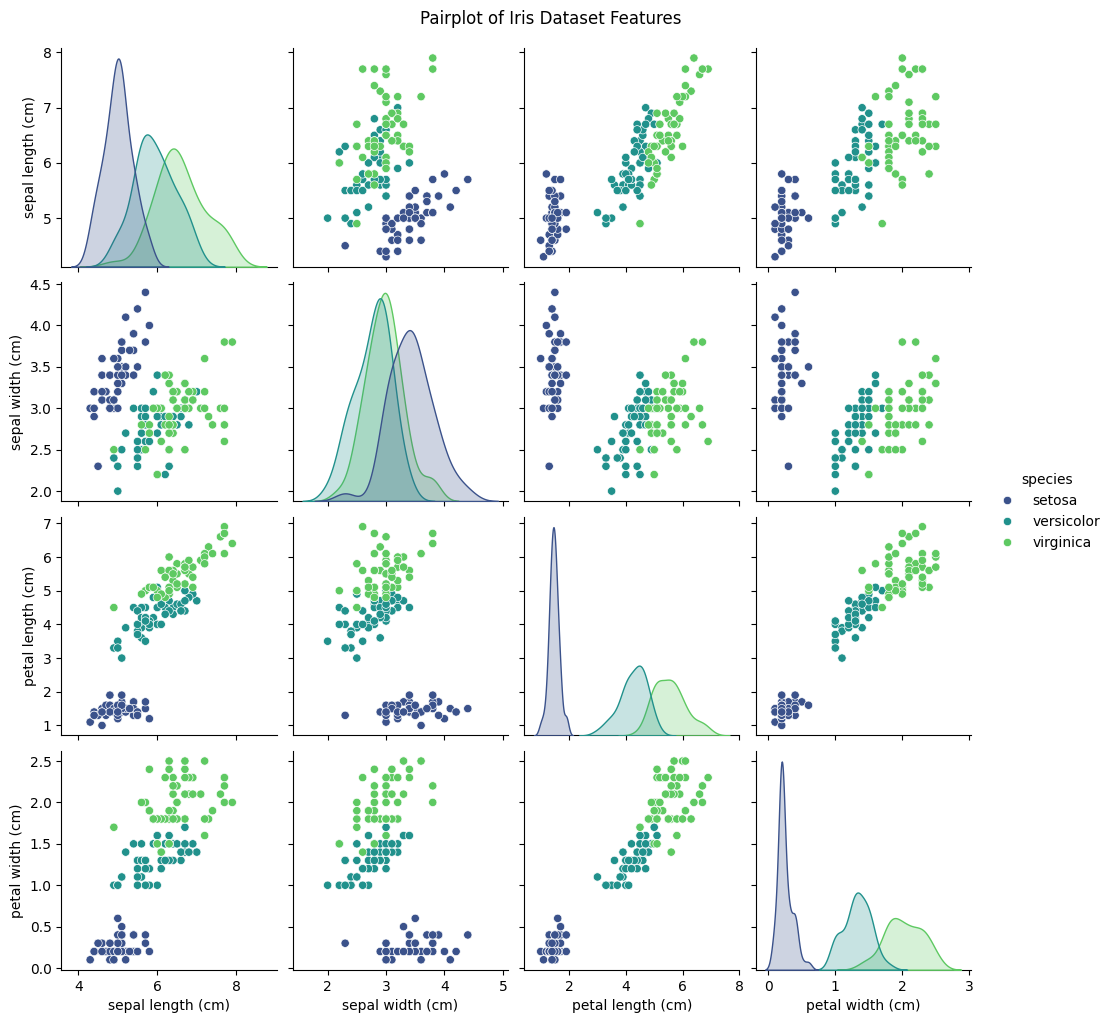

In [ ]:
# Create a pairplot to visualize relationships between features
plt.figure(figsize=(15, 10))

# Extract data for plotting
data = df.to_pandas()
sns.pairplot(data, hue='species', palette='viridis')
plt.suptitle('Pairplot of Iris Dataset Features', y=1.02)
plt.show();

**Data Preprocessing**

In [4]:
# Select only the numeric feature columns
numeric_df = df.select([col for col in df.columns if col != 'species'])

# Convert to numpy array for standardization
X = numeric_df.to_numpy()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to polars DataFrame
scaled_df = pl.DataFrame(
    X_scaled,
    schema=[f"{col}_scaled" for col in numeric_df.columns]
)

print("Standardized Features:")
display(scaled_df.head())

Standardized Features:


sepal length (cm)_scaled,sepal width (cm)_scaled,petal length (cm)_scaled,petal width (cm)_scaled
f64,f64,f64,f64
-0.900681,1.019004,-1.340227,-1.315444
-1.143017,-0.131979,-1.340227,-1.315444
-1.385353,0.328414,-1.397064,-1.315444
-1.506521,0.098217,-1.283389,-1.315444
-1.021849,1.249201,-1.340227,-1.315444


**Elbow Method**

Finding optimal k:   0%|          | 0/10 [00:00<?, ?it/s]

K=1: Inertia=600.00, Time=0.0077s
K=2: Inertia=222.36, Time=0.0112s
K=3: Inertia=139.82, Time=0.0172s
K=4: Inertia=114.09, Time=0.0193s
K=5: Inertia=90.93, Time=0.0244s
K=6: Inertia=81.54, Time=0.0277s
K=7: Inertia=72.63, Time=0.0555s
K=8: Inertia=62.54, Time=0.0327s
K=9: Inertia=55.12, Time=0.0388s
K=10: Inertia=47.39, Time=0.0248s


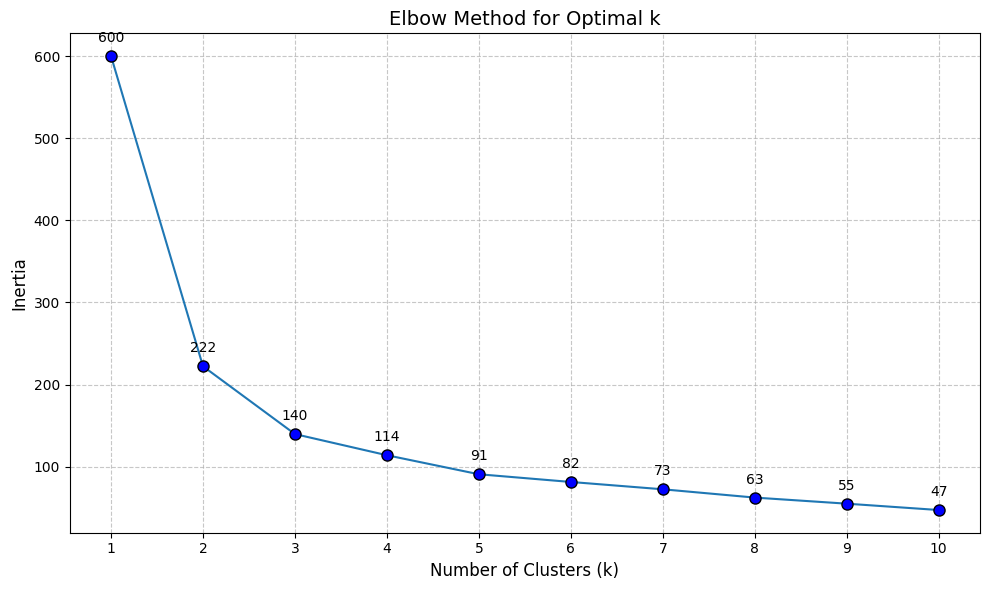

In [8]:
# Define range of k values to try
k_range = range(1, 11)

# Initialize empty list to store inertia values
inertias = []

# Use tqdm to display progress bar
for k in tqdm(k_range, desc="Finding optimal k"):
    # Measure time for performance comparison
    start_time = time.time()
    
    # Create and fit KMeans model
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    
    # Store inertia (sum of squared distances to closest centroid)
    inertias.append(kmeans.inertia_)
    
    elapsed_time = time.time() - start_time
    print(f"K={k}: Inertia={kmeans.inertia_:.2f}, Time={elapsed_time:.4f}s")

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'o-', markersize=8, markerfacecolor='blue', markeredgecolor='black')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.xticks(k_range)

# Add annotations
for i, k in enumerate(k_range):
    plt.annotate(f"{inertias[i]:.0f}", 
                 (k, inertias[i]), 
                 textcoords="offset points",
                 xytext=(0,10), 
                 ha='center')

plt.tight_layout()
plt.show()

**Clustering with Optimal K**

In [6]:
# From the elbow plot, determine the optimal k
optimal_k = 3  # Modify this based on your elbow plot analysis

# Apply K-Means clustering with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original dataframe
result_df = df.with_columns(pl.Series(name="cluster", values=clusters))

# View the results
print("Clustering Results:")
display(result_df.head())

# Compare clusters with original species
print("\nCluster vs. Species Distribution:")
display(result_df.group_by(['species', 'cluster']).agg(pl.count().alias('count')))

Clustering Results:


sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,cluster
f64,f64,f64,f64,str,i32
5.1,3.5,1.4,0.2,"""setosa""",1
4.9,3.0,1.4,0.2,"""setosa""",1
4.7,3.2,1.3,0.2,"""setosa""",1
4.6,3.1,1.5,0.2,"""setosa""",1
5.0,3.6,1.4,0.2,"""setosa""",1



Cluster vs. Species Distribution:


/tmp/ipykernel_925073/2555711649.py:17: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  display(result_df.group_by(['species', 'cluster']).agg(pl.count().alias('count')))


species,cluster,count
str,i32,u32
"""setosa""",1,50
"""versicolor""",0,39
"""virginica""",0,14
"""virginica""",2,36
"""versicolor""",2,11


**Visualization**

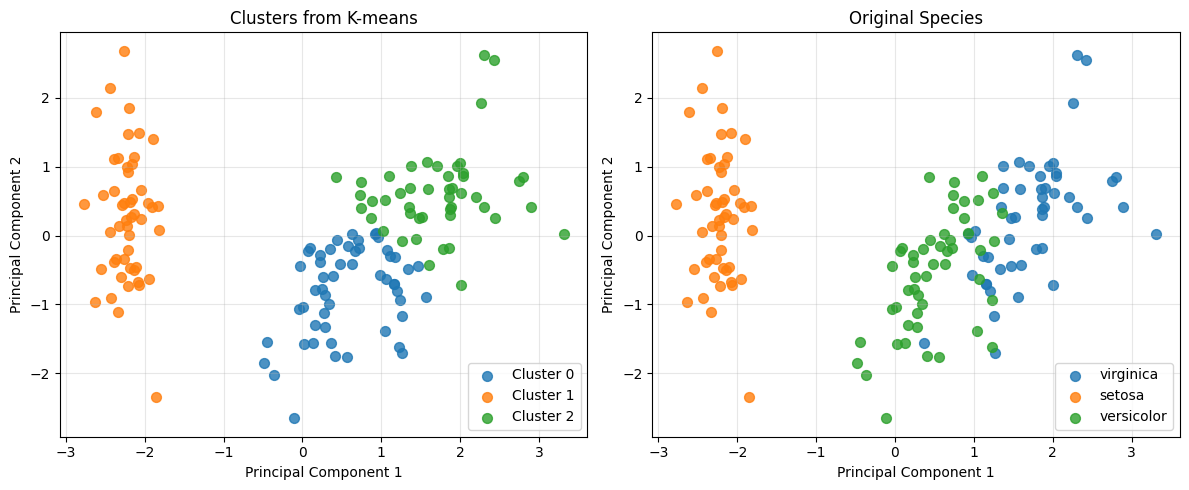

In [7]:
# Use PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

# Create a DataFrame with PCA results
pca_df = pl.DataFrame({
    'PCA1': pca_result[:, 0],
    'PCA2': pca_result[:, 1],
    'Cluster': clusters,
    'Species': df['species'].to_list()
})

# Plot the clusters
plt.figure(figsize=(12, 5))

# Plot 1: Colored by Clusters
plt.subplot(1, 2, 1)
for cluster in range(optimal_k):
    subset = pca_df.filter(pl.col('Cluster') == cluster).to_pandas()
    plt.scatter(subset['PCA1'], subset['PCA2'], label=f'Cluster {cluster}', s=50, alpha=0.8)
plt.title('Clusters from K-means')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(alpha=0.3)

# Plot 2: Colored by Original Species
plt.subplot(1, 2, 2)
species_list = df['species'].unique().to_list()
for species in species_list:
    subset = pca_df.filter(pl.col('Species') == species).to_pandas()
    plt.scatter(subset['PCA1'], subset['PCA2'], label=species, s=50, alpha=0.8)
plt.title('Original Species')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()